In [23]:
import sys
import os
import tifffile, palom, cv2
from skimage.filters import median, gaussian
from skimage.morphology import disk
import dask.array as da
import pandas as pd
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter
import matplotlib.pyplot as plt
from loguru import logger
import skimage

In [9]:
logger.remove()
logger.add(sys.stderr, level="DEBUG")

1

In [4]:
image_path = '/Users/jnimoca/Jose_BI/data/segprep/5.ome.tif'

In [ ]:
output_folder_path = '/Users/jnimoca/Jose_BI/data/segprep/output/'

In [10]:
def separate_channels(image, markers_path:str):
    logger.info(f"Separating channels")
    
    df = pd.read_csv(markers_path)

    df['nuclear_markers'] = df['nuclear_markers'].notnull()
    df['membrane_markers'] = df['membrane_markers'].notnull()
    
    if image.shape[1] == image.shape[2]:
        logger.debug(f"Image is CYX")
    elif image.shape[0] == image.shape[1]:
        logger.debug(f"Image is YXC")
        image = np.moveaxis(image, 0, -1)
        logger.debug(f"Image shape is now {image.shape}")
    
    img_nuclear = image[df['nuclear_markers'],:,:]
    img_membrane = image[df['membrane_markers'],:,:]
    return img_nuclear, img_membrane

In [11]:
nuclear_img, membrane_img = separate_channels(tifffile.imread(image_path), '/Users/jnimoca/Jose_BI/data/segprep/markers.csv')

2024-06-10 13:36:08.215 | INFO     | __main__:separate_channels:2 - Separating channels
2024-06-10 13:36:08.241 | DEBUG    | __main__:separate_channels:10 - Image is CYX


# Proccess nuclear image

In [12]:
nuclear_img.shape

(8, 8319, 8319)

In [17]:
s1, s2 = (1500,2000)

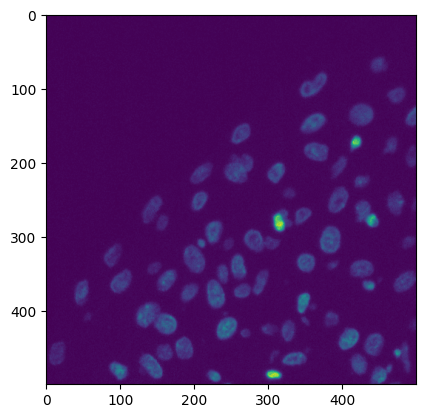

In [22]:
plt.imshow(nuclear_img[0,s1:s2,s1:s2])

In [20]:
image = np.quantile(nuclear_img, 0.75, axis=0)

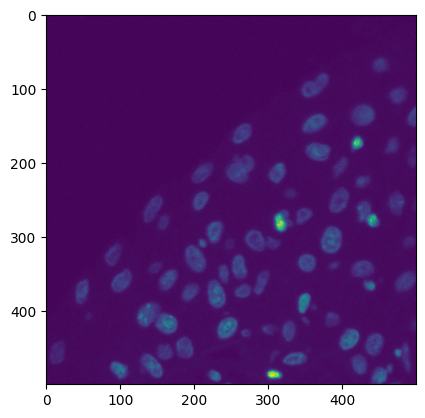

In [21]:
plt.imshow(image[s1:s2,s1:s2])

## Showing the process of median subtraction

In [ ]:
# orginal function
def median_subtraction(image):
    logger.info(f"Subtracting median")
    image_shape = image.shape
    new_shape = (image_shape[1]//8, image_shape[2]//8)
    #blur it before down sampling
    blur_img = skimage.filters.median(image, selem=skimage.morphology.disk(3.5))
    #downscale the median filtered image to the new dimensions
    downscaled_blur_image = skimage.transform.resize(blur_img, new_shape, order=0)
    #blur the small image
    blurred_small_image = skimage.filters.median(downscaled_blur_image, selem=skimage.morphology.disk(50.5))
    #scale back up
    image_blurred = skimage.transform.resize(blurred_small_image, image_shape, order=0)
    #remove blurred image from original image
    image_median_removed = image - np.minimum(image_blurred, image)
    return image_median_removed

In [24]:
blur_img = skimage.filters.median(image, selem=skimage.morphology.disk(3.5))

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_50325/1423044157.py:1: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  blur_img = skimage.filters.median(image, selem=skimage.morphology.disk(3.5))


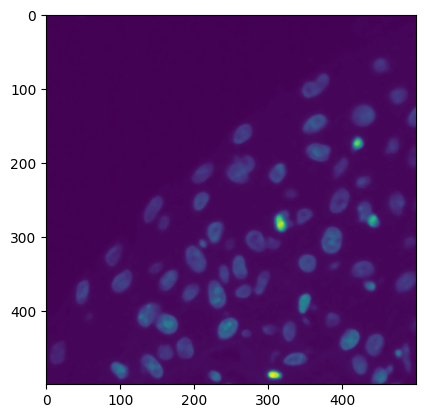

In [25]:
plt.imshow(blur_img[s1:s2,s1:s2])

In [26]:
#downscale the median filtered image to the new dimensions
downscaled_blur_image = skimage.transform.resize(blur_img, (image.shape[0]//8,image.shape[1]//8), order=0)

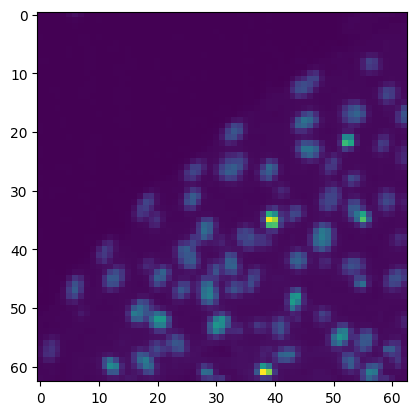

In [27]:
plt.imshow(downscaled_blur_image[s1//8:s2//8,s1//8:s2//8])

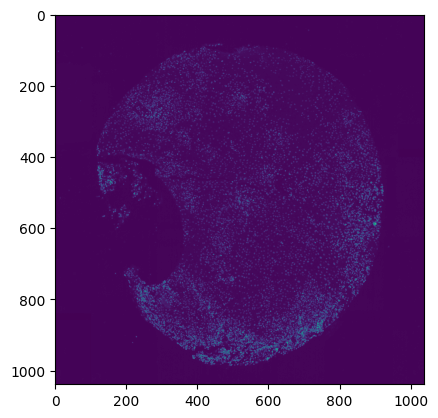

In [31]:
plt.imshow(downscaled_blur_image)

In [28]:
blurred_small_image = skimage.filters.median(downscaled_blur_image, selem=skimage.morphology.disk(50.5))

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_50325/2323854941.py:1: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  blurred_small_image = skimage.filters.median(downscaled_blur_image, selem=skimage.morphology.disk(50.5))


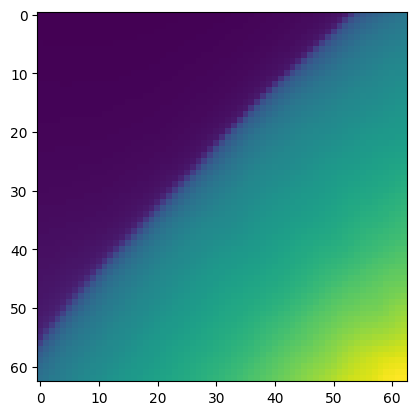

In [29]:
plt.imshow(blurred_small_image[s1//8:s2//8,s1//8:s2//8])

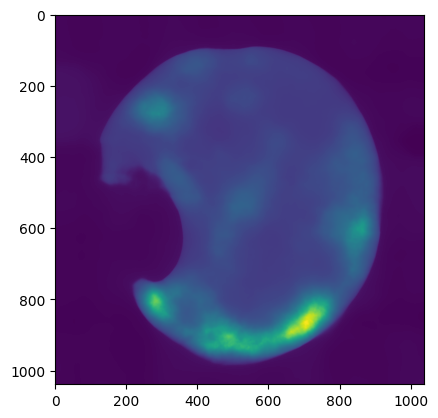

In [30]:
plt.imshow(blurred_small_image)

In [32]:
image_blurred = skimage.transform.resize(blurred_small_image, image.shape, order=0)

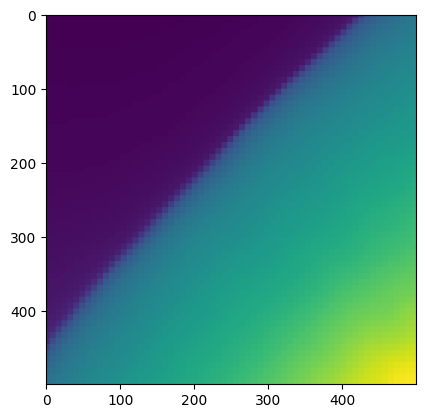

In [33]:
plt.imshow(image_blurred[s1:s2,s1:s2])

In [34]:
image_median_removed = image - np.minimum(image_blurred, image)

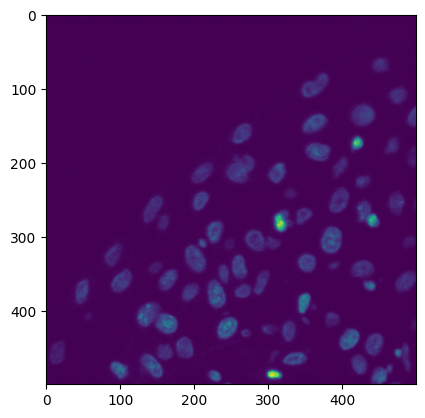

In [35]:
plt.imshow(image_median_removed[s1:s2,s1:s2])

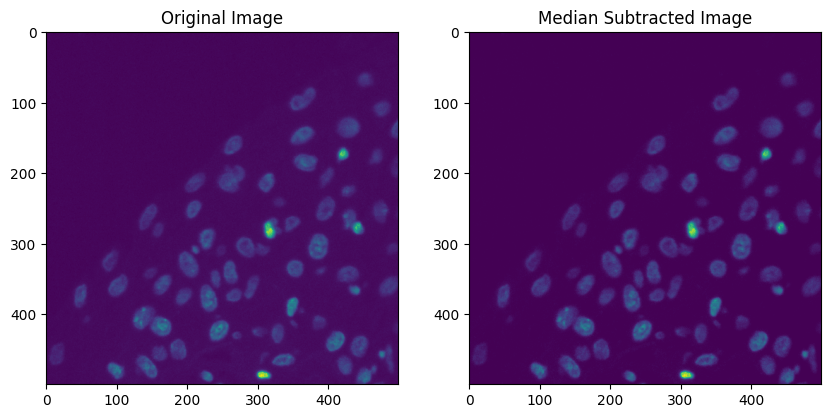

In [36]:
#plot image and median subtracted image in one plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image[s1:s2,s1:s2])
ax[0].set_title('Original Image')
ax[1].imshow(image_median_removed[s1:s2,s1:s2])
ax[1].set_title('Median Subtracted Image')
plt.show()

## Back to processing nuclear image

In [37]:
image2 = skimage.filters.median(image_median_removed, selem=skimage.morphology.disk(1.5))

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_50325/3386017007.py:1: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  image2 = skimage.filters.median(image_median_removed, selem=skimage.morphology.disk(1.5))


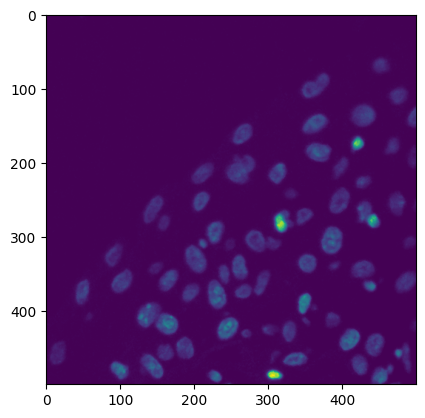

In [40]:
plt.imshow(image2[s1:s2,s1:s2])

In [41]:
scaled_image = image - np.quantile(image, 0.75)
scaled_image[scaled_image < 0] = 0
scaled_image = scaled_image / np.quantile(scaled_image, 0.99)
scaled_image[scaled_image > 1] = 1

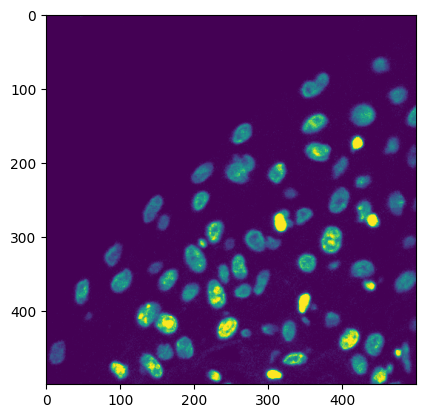

In [42]:
plt.imshow(scaled_image[s1:s2,s1:s2])

In [43]:
scaled_image = scaled_image * 255
scaled_image = scaled_image.astype(np.uint8)

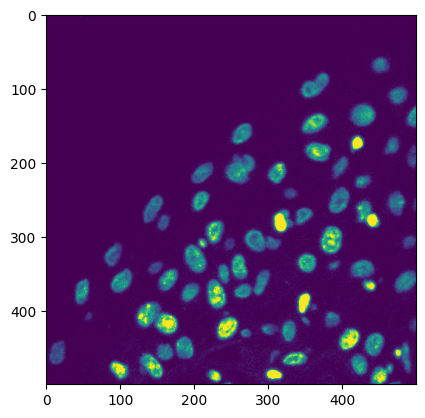

In [44]:
plt.imshow(scaled_image[s1:s2,s1:s2])

 # Nuclear signal processing done!

In [ ]:
# membrane signal processing v1
cytosol_img = np.quantile(cytosol_img, 0.75, axis=0)
cytosol_img = median_blur_remove(cytosol_img)
cytosol_img = median(cytosol_img, disk(1.5))
cytosol_img[cytosol_img < 0] = 0
cytosol_img = maximum_filter(cytosol_img, size=(3, 3))
cytosol_img = median(cytosol_img, disk(3))
cytosol_img = cytosol_img - np.quantile(cytosol_img, 0.75)
cytosol_img[cytosol_img < 0] = 0
cytosol_img = cytosol_img / np.quantile(cytosol_img, 0.995)
cytosol_img[cytosol_img > 1] = 1
cytosol_img = cytosol_img * 255
cytosol_img = cytosol_img.astype(np.uint8)
cytosol_img = np.maximum(cytosol_img, nucleus_img)

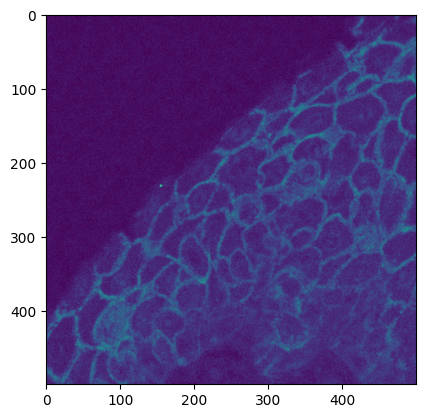

In [63]:
quantiled_image = np.quantile(membrane_img, 0.75, axis=0)
plt.imshow(quantiled_image[s1:s2,s1:s2]) 

## median subtraction

In [64]:
# orginal function
def median_subtraction(image):
    logger.info(f"Subtracting median")
    image_shape = image.shape
    new_shape = (image_shape[1]//8, image_shape[2]//8)
    #blur it before down sampling, takes care of hot pixels, local noise
    blur_img = skimage.filters.median(image, selem=skimage.morphology.disk(3.5))
    #downscale the median filtered image to the new dimensions
    downscaled_blur_image = skimage.transform.resize(blur_img, new_shape, order=0)
    #blur the small image
    blurred_small_image = skimage.filters.median(downscaled_blur_image, selem=skimage.morphology.disk(50.5))
    #scale back up
    image_blurred = skimage.transform.resize(blurred_small_image, image_shape, order=0)
    #remove blurred image from original image
    image_median_removed = image - np.minimum(image_blurred, image)
    return image_median_removed

In [65]:
image_shape = quantiled_image.shape
new_shape = (image_shape[0]//8, image_shape[1]//8)

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_50325/1394710513.py:2: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  blur_img = skimage.filters.median(quantiled_image, selem=skimage.morphology.disk(3.5))


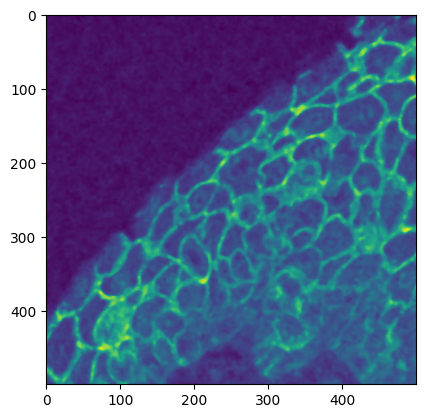

In [66]:
#blur it before down sampling
blur_img = skimage.filters.median(quantiled_image, selem=skimage.morphology.disk(3.5))
plt.imshow(blur_img[s1:s2,s1:s2])

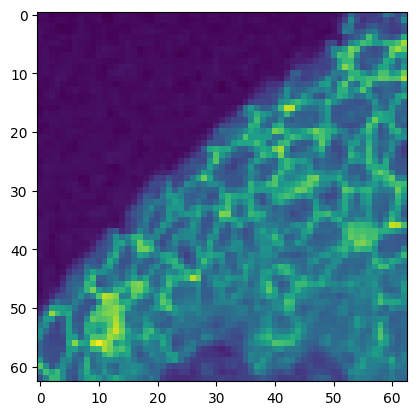

In [67]:
#downscale the median filtered image to the new dimensions
downscaled_blur_image = skimage.transform.resize(blur_img, new_shape, order=0)
plt.imshow(downscaled_blur_image[s1//8:s2//8,s1//8:s2//8])

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_50325/1327609152.py:2: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  blurred_small_image = skimage.filters.median(downscaled_blur_image, selem=skimage.morphology.disk(50.5))


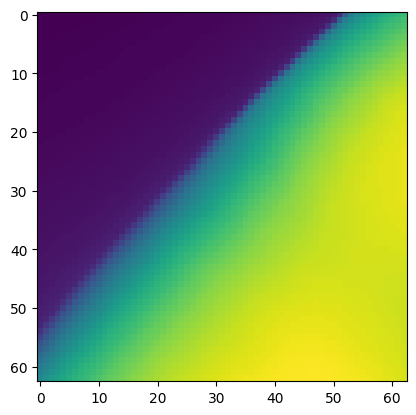

In [76]:
#blur the small image
blurred_small_image = skimage.filters.median(downscaled_blur_image, selem=skimage.morphology.disk(50.5))
plt.imshow(blurred_small_image[s1//8:s2//8,s1//8:s2//8])

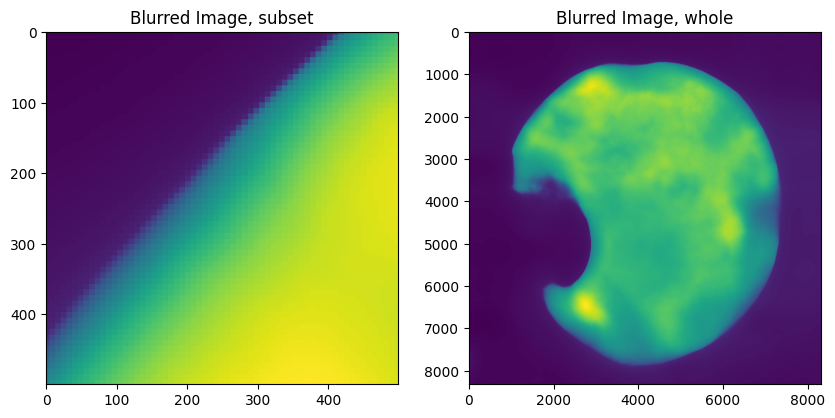

In [77]:
#scale back up
image_blurred = skimage.transform.resize(blurred_small_image, image_shape, order=0)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_blurred[s1:s2,s1:s2])
ax[0].set_title('Blurred Image, subset')
ax[1].imshow(image_blurred)
ax[1].set_title('Blurred Image, whole')
plt.show()

In [84]:
#remove blurred image from original image
mem_median_removed = quantiled_image - np.minimum(image_blurred, quantiled_image)

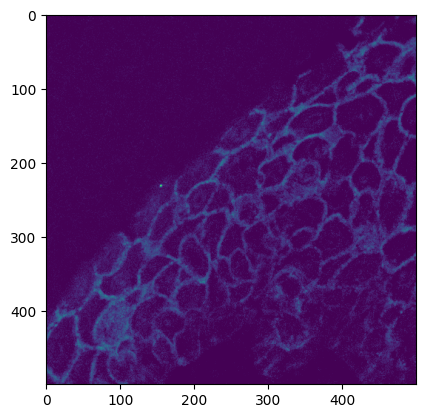

In [87]:
plt.imshow(mem_median_removed[s1:s2,s1:s2])

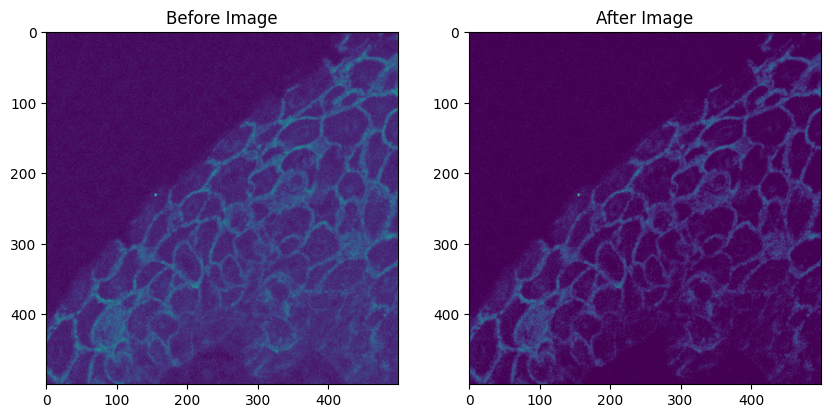

In [89]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(quantiled_image[s1:s2,s1:s2])
ax[0].set_title('Before Image')
ax[1].imshow(mem_median_removed[s1:s2,s1:s2])
ax[1].set_title('After Image')
plt.show()